In [2]:
import torch
import torchvision
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.ToTensor()
# Download and load the training data
trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [7]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            # Input layer
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            
            # Hidden layers
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            
            # Output layer
            nn.Linear(1024, 784),  # 28x28 = 784 (MNIST image size)
            nn.Tanh()
        )
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # Input layer
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Hidden layers
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Output layer
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
n_epochs = 100

# Initialize networks and optimizers
generator = Generator(latent_dim)
discriminator = Discriminator()

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on device:", device)
generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

# Training loop
for epoch in range(n_epochs):
    for i, (real_imgs, _) in enumerate(trainloader):
        # Ground truths
        batch_size = real_imgs.size(0)
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)
        
        # Configure input
        real_imgs = real_imgs.to(device)
        
        # -----------------
        #  Train Generator
        # -----------------
        g_optimizer.zero_grad()
        # Generate a batch of images
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), real)
        g_loss.backward()
        g_optimizer.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        d_optimizer.zero_grad()
        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        d_optimizer.step()
        
        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(trainloader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )


Training on device: cuda
[Epoch 0/100] [Batch 0/938] [D loss: 0.6901] [G loss: 0.6830]
[Epoch 0/100] [Batch 100/938] [D loss: 0.6220] [G loss: 0.7393]
[Epoch 0/100] [Batch 200/938] [D loss: 0.4343] [G loss: 0.8495]
[Epoch 0/100] [Batch 300/938] [D loss: 0.7231] [G loss: 0.5620]
[Epoch 0/100] [Batch 400/938] [D loss: 0.1727] [G loss: 1.5540]
[Epoch 0/100] [Batch 500/938] [D loss: 0.4867] [G loss: 1.6693]
[Epoch 0/100] [Batch 600/938] [D loss: 0.6259] [G loss: 1.0950]
[Epoch 0/100] [Batch 700/938] [D loss: 0.2884] [G loss: 1.8832]
[Epoch 0/100] [Batch 800/938] [D loss: 0.2011] [G loss: 1.8246]
[Epoch 0/100] [Batch 900/938] [D loss: 0.3183] [G loss: 1.8405]
[Epoch 1/100] [Batch 0/938] [D loss: 0.1763] [G loss: 2.3589]
[Epoch 1/100] [Batch 100/938] [D loss: 0.1337] [G loss: 2.5218]
[Epoch 1/100] [Batch 200/938] [D loss: 0.1888] [G loss: 1.9442]
[Epoch 1/100] [Batch 300/938] [D loss: 0.4322] [G loss: 1.3840]
[Epoch 1/100] [Batch 400/938] [D loss: 0.0788] [G loss: 2.6367]
[Epoch 1/100] [Batc

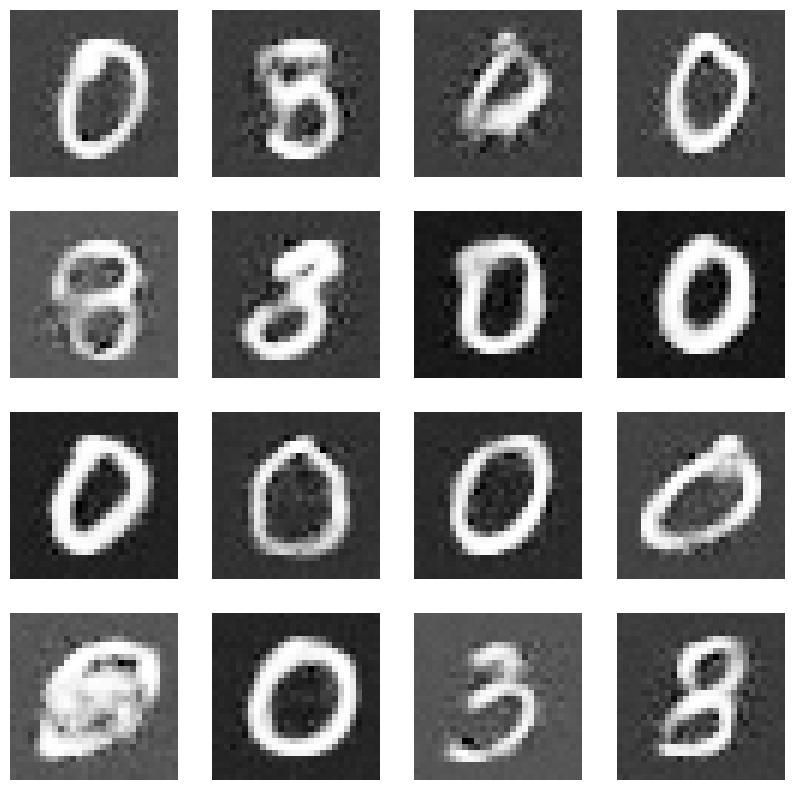

In [8]:
# Function to generate and display images
def generate_images(num_images=16):
    z = torch.randn(num_images, latent_dim).to(device)
    generator.eval()
    with torch.no_grad():
        generated_images = generator(z).cpu()
    
    # Display the images
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()
generate_images()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Hyperparameters
latent_dim = 100
image_channels = 1  # 1 for MNIST (grayscale)
feature_dim = 64    # Number of features to start with
lr = 0.0002
beta1 = 0.5
n_epochs = 200

# Generator Network
class DCGenerator(nn.Module):
    def __init__(self, latent_dim):
        super(DCGenerator, self).__init__()
        
        self.model = nn.Sequential(
            # Input is latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_dim * 8),
            nn.ReLU(True),
            # State: (feature_dim*8) x 4 x 4
            
            nn.ConvTranspose2d(feature_dim * 8, feature_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 4),
            nn.ReLU(True),
            # State: (feature_dim*4) x 8 x 8
            
            nn.ConvTranspose2d(feature_dim * 4, feature_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 2),
            nn.ReLU(True),
            # State: (feature_dim*2) x 16 x 16
            
            nn.ConvTranspose2d(feature_dim * 2, image_channels, 4, 2, 3, bias=False),
            nn.Tanh()
            # Final State: image_channels x 28 x 28
        )

    def forward(self, z):
        # Reshape input to be 4D: batch_size x latent_dim x 1 x 1
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.model(z)

# Discriminator Network
class DCDiscriminator(nn.Module):
    def __init__(self):
        super(DCDiscriminator, self).__init__()
        
        self.model = nn.Sequential(
            # Input is image_channels x 28 x 28
            nn.Conv2d(image_channels, feature_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: feature_dim x 14 x 14
            
            nn.Conv2d(feature_dim, feature_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (feature_dim*2) x 7 x 7
            
            nn.Conv2d(feature_dim * 2, feature_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (feature_dim*4) x 4 x 4
            
            nn.Conv2d(feature_dim * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Final State: 1 x 1 x 1
        )

    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)

# Initialize networks and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = DCGenerator(latent_dim).to(device)
discriminator = DCDiscriminator().to(device)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Setup optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = nn.BCELoss()

# Training Loop
print("Starting Training...")

for epoch in range(n_epochs):
    for i, (real_imgs, _) in enumerate(trainloader):
        batch_size = real_imgs.size(0)
        
        # Configure input
        real_imgs = real_imgs.to(device)
        
        # Ground truths
        real_label = torch.ones(batch_size).to(device)
        fake_label = torch.zeros(batch_size).to(device)

        # -----------------
        #  Train Discriminator
        # -----------------
        d_optimizer.zero_grad()
        
        # Train with real
        d_output_real = discriminator(real_imgs)
        d_loss_real = criterion(d_output_real, real_label)
        
        # Train with fake
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(noise)
        d_output_fake = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(d_output_fake, fake_label)
        
        # Combined D loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # -----------------
        #  Train Generator
        # -----------------
        g_optimizer.zero_grad()
        
        # Generate new images
        gen_output = discriminator(fake_imgs)
        g_loss = criterion(gen_output, real_label)
        
        g_loss.backward()
        g_optimizer.step()
        
        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(trainloader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )

    # Save some generated images at the end of each epoch
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake_imgs = generator(torch.randn(16, latent_dim).to(device)).cpu()
            torchvision.utils.save_image(fake_imgs, f"fake_images_epoch_{epoch+1}.png", 
                                       normalize=True, nrow=4)

# Function to generate and display images
def generate_dcgan_images(num_images=16):
    z = torch.randn(num_images, latent_dim).to(device)
    generator.eval()
    with torch.no_grad():
        generated_images = generator(z).cpu()
    
    # Display the images
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()